In [72]:
#import pyspark, jieba
#from bs4 import BeautifulSoup

import sys, json, time, os, csv, faiss
from gensim import corpora, models 
from gensim.models import word2vec
import multiprocessing
import numpy as np

ModuleNotFoundError: No module named 'gensim'

In [73]:
!ls /home/data/ncku_released/

ls: cannot access /home/data/ncku_released/: No such file or directory


In [3]:
#os.environ["SPARK_HOME"] = "/opt/spark/spark"
#os.environ["PYSPARK_PYTHON"] = "/net/account/pixuser/wayne/python-env/p362/bin/python"
sc = pyspark.SparkContext()
jieba.set_dictionary('/net/account/pixuser/wayne/work/pixcppjieba/dict/user.dict.utf8')

In [4]:
article_path = '/home/data/ncku_released/'


with open('/net/account/pixuser/wayne/work/pixcppjieba/dict/stoplist.txt') as f:
    stop_terms = set(f.read().splitlines())
stop_terms = set([x.lower() for x in stop_terms])
stop_terms = stop_terms | set(['0','1','2','3','4','5','6','7','8','9','10','11','12','-','+','\n',
                              'blogger','http','tw','blogspot','2014','05','blog','post','html','net','category','1807959','2013','fb','google'])
print ("stop_terms:",len(stop_terms))

stop_terms_sc = sc.broadcast(stop_terms)

stop_terms: 2466


In [5]:
def article2seq(content):
    stop_word = stop_terms_sc.value
    r = []
    try:
        soup = BeautifulSoup(content, 'lxml')
    except :
        print ('BeautifulSoup Parse Error')
        return []
    word_list = jieba.lcut(soup.getText(), cut_all=False)  
    for word in word_list: 
        if len(word) < 2 or word in stop_word:
            continue
        r.append(word.lower().strip())
    return ' '.join(r)

In [6]:
sc.textFile(os.path.join(article_path, 'articles_200k.jl')).map(json.loads) \
    .map(lambda x: article2seq(x['body'])).saveAsTextFile(os.path.join(article_path, 'cut_200k'))

In [7]:
pixnet_corpus = sc.textFile(os.path.join(article_path, 'cut_200k') + '/p*') \
    .map(lambda x: x.lower()).map(lambda x: x.split()) \
    .map(lambda x: [w.strip() for w in x]).take(10000)

In [22]:
len(pixnet_corpus)

10000

In [111]:
%matplotlib inline

In [112]:
!ls /net/account/pixuser/wayne/work/glove

ls: cannot access /net/account/pixuser/wayne/work/glove: No such file or directory


In [120]:
with open('../../glove/vectors_100.txt','r', encoding='utf8') as f:
    vec_raw = f.readlines()

In [121]:
import faiss
index_copurs = faiss.IndexFlatIP(256)
#index_copurs.add(arr.astype('float32'))

a = np.zeros(shape=(len(vec_raw),256))

In [122]:
a.shape

(73721, 256)

In [123]:
def multiply2(idx, item):
    raw = item.strip().split()
    word = raw[0]
    vec = raw[1:]
        
    return (word, vec)
    
#map(multiply2, vec_raw[0:3])

In [124]:
word_list = []
word_dict = {}

for idx, item in enumerate(vec_raw):
    rr= multiply2(idx, item)
    word_list.append(rr[0])
    a[idx] = list(map(float, rr[1]))
    word_dict[rr[0]] = idx

In [125]:
index_copurs.add(a.astype('float32'))

In [128]:
to_draw = {}

D, I = index_copurs.search(np.array([a[word_dict['牛排']]]).astype('float32'), 15)
for idx_d, idx_c in enumerate(I[0]): 
    #if _idx == 1:
    print(word_list[idx_c], idx_c, idx_d, D[0][idx_d])
    to_draw[word_list[idx_c]] = D[0][idx_d]
    #target_distance[idx_c] += D[0][idx_d]

牛排 124 0 65.956375
牛肉 41 1 33.73111
肋眼 4115 2 28.540005
料理 15 3 28.487206
好吃 2 4 28.024342
套餐 54 5 27.272768
台北 12 6 27.202969
日本料理 770 7 27.08363
美味 36 8 26.94558
份量 111 9 26.309319
美食 7 10 25.995705
餐廳 8 11 24.894659
沙朗 4110 12 24.81033
肉質 292 13 24.469156
懶人包 164 14 24.318192


(-0.5, 599.5, 599.5, -0.5)

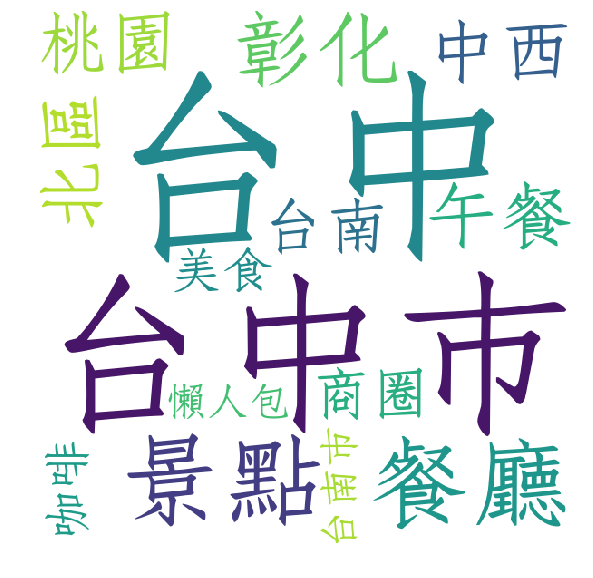

In [110]:
wordcloud = WordCloud(
                      font_path='../../font/cwTeXQFangsong-Medium.ttf',
                      background_color='white',
                      width=600,
                      height=600,
                    max_words = 25
                     ).generate_from_frequencies(to_draw, max_font_size=None)
plt.figure(figsize=(10, 10))

plt.imshow(wordcloud)
plt.axis('off')

In [71]:
with open('../../glove/pixnet_10000.txt','r', encoding='utf8') as f:
    corpus = f.readlines()

In [78]:
qq = [article.strip().split() for article in corpus]

In [85]:
%time
# Build Word2Vec# Build 
#ms = MySentences('../../glove/pixnet_10000.txt')
model = gensim.models.Word2Vec(qq, size=100, window=15, min_count=5, workers=32, sg=1, negative=5)
#model = models.Word2Vec(ms, size=100, window=5, min_count=5, workers=32)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.6 µs


In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [96]:
to_draw = {}

slist = model.most_similar(positive=['台中'],topn=15)
for word , score in slist :
    to_draw[word] = (score ** 4) * 100
    print (word, (score ** 4) * 100)

NameError: name 'model' is not defined

(-0.5, 599.5, 599.5, -0.5)

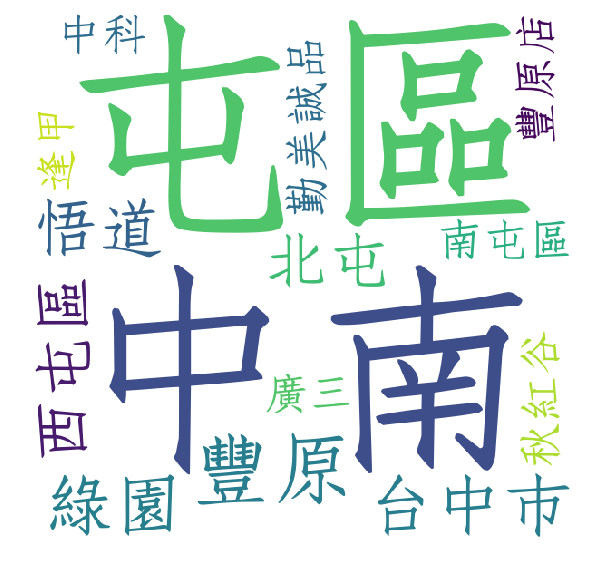

In [124]:
wordcloud = WordCloud(
                      font_path='../../font//cwTeXQFangsong-Medium.ttf',
                      background_color='white',
                      width=600,
                      height=600,
                    max_words = 25
                     ).generate_from_frequencies(to_draw, max_font_size=None)
plt.figure(figsize=(10, 10))

plt.imshow(wordcloud)
plt.axis('off')

In [117]:
%time
model_cbow = gensim.models.Word2Vec(qq, size=100, window=15, min_count=5, workers=32, sg=0, negative=5)
#model = models.Word2Vec(ms, size=100, window=5, min_count=5, workers=32)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.2 µs


In [125]:
to_draw = {}

slist = model_cbow.most_similar(positive=['台中'],topn=15)
for word , score in slist :
    to_draw[word] = (score ** 4) * 100
    print (word, (score ** 4) * 100)

中南 61.60012942439928
北屯 52.99284788189803
屯區 52.55463119307733
嘉義市 51.8324283978683
綠園 50.318341103311795
嘉義旅遊 47.36768538036948
悟道 47.004614922593156
太初 46.6554247331202
力作 45.87242363505165
新開幕 44.10549542110789
勤美誠品 43.16113631958658
南屯 42.03465005927439
尚順 41.17471768073386
東海 40.127111046832766
金典 39.95520784991183


/net/account/pixuser/wayne/python-env/p362/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 599.5, 599.5, -0.5)

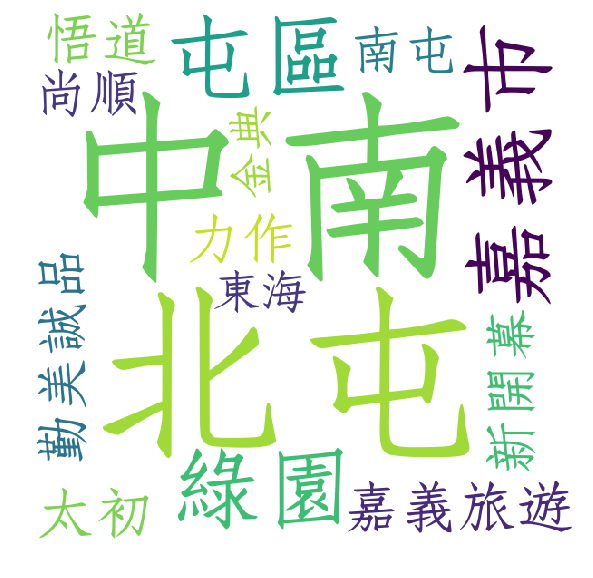

In [126]:
wordcloud = WordCloud(
                      font_path='../../font//cwTeXQFangsong-Medium.ttf',
                      background_color='white',
                      width=600,
                      height=600,
                    max_words = 25
                     ).generate_from_frequencies(to_draw, max_font_size=None)
plt.figure(figsize=(10, 10))

plt.imshow(wordcloud)
plt.axis('off')